# Data Cleaning
In this notebook, I'll look at the data and deal with missing values. Also excluding dataset with data quality deemed suspicious based on the original document (https://github.com/stanford-policylab/opp/blob/master/data_readme.md)

In [49]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.set_option('display.expand_frame_repr', False)
pd.set_option('precision', 4)
pd.options.display.max_seq_items = None

In [72]:
df0 = pd.read_csv('DATA/full_df.csv', index_col = 0, dtype = object)

In [73]:
#df.columns

In [74]:
# lower case columns to make it searchable
df0.columns = [x.lower() for x in df0.columns]

## Raw Data
Raw data are original data. I'll separate these out since we may not need to use it.

In [75]:
RAW = df0[df0.columns[df0.columns.str.startswith('raw')]]

In [76]:
df = df0.drop(RAW[1:], axis = 1)

## Missing values & Subsetting Data
There are many missing values. I'll use outcome as a target variable and drop missing outcome (should not infer target variable).

In [80]:
df.outcome.isnull().sum()

103262

In [84]:
df.outcome.value_counts()

citation    193921
warning      96064
arrest       10431
summons       2580
Name: outcome, dtype: int64

In [81]:
df = df.dropna(subset = ['outcome'])

Some columnns are just breakdown of outcome. I'll remove those.

In [85]:
df = df.drop(['citation_issued', 'warning_issued', 'arrest_made'], axis = 1)

Some columns are post-outcome occurrences, I'll remove those.

In [87]:
df = df.drop(['reason_for_arrest'], axis = 1)

Hardfort, CT dataset was considered 'suspicious' by others who have made the cleaned individual dataset from raw data. I'll remove those.

In [94]:
df = df.loc[df.fname != 'ct_hartford_2020_04_01.csv',:]

Remove a column if it's missing majority of the data.

In [107]:
df = df.drop(df.columns[df.isnull().sum() > (len(df)/2)], axis = 1)

Remove the entire location if the location misses majority of race and sex information.

In [133]:
tmp = df.groupby('fname').agg({
                        'subject_race': lambda x: x.isnull().sum()/len(x), 
                        'subject_sex': lambda x: x.isnull().sum()/len(x)})

In [143]:
to_remove = list(tmp[(tmp.subject_race > 0.5) | (tmp.subject_sex > 0.5)].index)

In [149]:
df = df[~df.fname.isin(to_remove)]

Remove all info with missing race and sex information (key predictor without means to infer value)

In [164]:
df = df.dropna(subset = ['subject_race', 'subject_sex'])

### Age
Impute median value since the data is right skewed.

In [179]:
df['subject_age'] = df.subject_age.astype('int64', errors = 'ignore')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


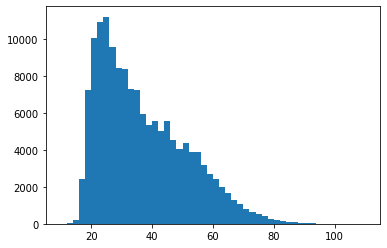

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline
tmp = [int(x) for x in df.subject_age[~df.subject_age.isnull()]]
plt.hist(tmp, bins = 50)
plt.show()

In [199]:
df.subject_age = df.subject_age.fillna(df.subject_age.median())

In [200]:
df.isnull().sum()

date                     0
time                 38390
lat                 107082
lng                 107087
subject_age              0
subject_race             0
subject_sex              0
type                  5766
outcome                  0
fname                    0
location             36581
violation            98803
search_conducted     85522
dtype: int64